# Memory in Python

## Contents
- Memory management in Python
    - Objects and addresses
    - Object references
    - Garbage collection
- Monitor/observe memory usage
    - Single line of code
    - One function call
- Handling memory-related issues
    - Memory mapping
    - General considerations

# Memory management in Python

### Objects
Classes, functions, and even simple data types, such as integers, floats, and strings, are represented as 'objects' in memory.

In [1]:
import sys

print("empty dict: ", sys.getsizeof({}))
print("empty list: ", sys.getsizeof([]))
print("empty set: ", sys.getsizeof(set()))
print("empty string: ", sys.getsizeof(""))

empty dict:  64
empty list:  56
empty set:  216
empty string:  41


Evidently, Python objects have a fixed overhead (in bytes, 1 byte = 8 bits) that varies from one object type to another. This overhead is needed to support dynamic numerical ranges (for example - int type does not have a limited range like C int has; the only limit is the available memory), the current size of the dynamic storage, and object bookkeeping such as a reference to the relevant object and a reference count.

Check ASCII Table
[ASCII Character](https://www.ascii-code.com/)

In [3]:
title = "BIOE-488" # string of 8 characters
sys.getsizeof(title) # 1 byte per character in string --> If ASCII

49

An empty string takes 41 bytes, and each additional character adds another byte (41 + 8 = 49). That says a lot about the tradeoffs of keeping multiple short strings where you'll pay the 41 bytes overhead for each one vs. a single long string where you pay the overhead only once.

In [4]:
title = "BIOE-488"+"\U0001F60A"
print(title)
sys.getsizeof(title) # 4 byte per character in string --> If Unicode

BIOE-488😊


96

In [5]:
a = True # represented as integer 1
b = False # represented as integer 0
print(sys.getsizeof(True))
print(sys.getsizeof(False))
print(sys.getsizeof(a))
print(sys.getsizeof(b))

28
28
28
28


Booleans are stored as integers. An integer is represented by a sequence of 4-byte chunks. An empty integer object such as False/0 contains no filled chunks. As soon as you actually have an int value > 0, which is the case with True/1, the integer object's chunk array isn't empty anymore as one 4-byte chunk gets filled. Read more - https://stackoverflow.com/questions/49926843/why-is-a-false-value-0-smaller-in-bytes-than-true-1

In [6]:
import sys
a = 12313423342343234563434543453434636 # try to fill more chunks of the integer data array
print(sys.getsizeof(a))

40


In [7]:
# We can import special datatytpes
from decimal import Decimal
print(sys.getsizeof(Decimal(1.0)))
print(sys.getsizeof(1.0))

104
24


In [8]:
import numpy as np
alist = [a]
sys.getsizeof(alist)

64

Remember that empty `[]` itself takes up 56 bytes, so 64 - 56 = 8 bytes of new memory was added to the list `[]`. But since `a` is an integer, should it not take at least the minimum 28 bytes (one chunk filled) overhead shown above?

It turns out the list doesn't contain the int objects themselves. It just contains an 8-byte pointer (size varies from system to system) to the actual int object. What that means is that the `getsizeof()` doesn't return the actual memory of the list and all the objects it contains, but only the memory of the list and the pointers to its objects.



In [9]:
b = "BIOE 488"
c = 12345
d = 10.1234
blist = [a, b, c, d]
sys.getsizeof(blist)

88

**[Exercise] How can you explain 88? Why does 88 not change irrespective of what type of data the list contains?**

Answer:
[] takes 56 bytes. and the 4 pointers take 8 bytes each. So it is 56+32 = 88 bytes in total

### Memory addresses

Each object is stored in physical memory (RAM) at a particular address. How large an address is depends on the size of the physical memory of the system. The `id()` function returns the memory address of the input. We convert the output to the conventional hexadecimal system using `hex()`.

In [10]:
print(id(b))

140614211613040


In [11]:
print("address of b: ", hex(id(b)))

address of b:  0x7fe34c223170


In [12]:
print("address of blist[3]: ", hex(id(blist[3])))

address of blist[3]:  0x7fe36d4d8d10


We can, in fact, verify the use of references seen in the above section by inspecting the memory addresses of variables and list elements. 

In [13]:
# Remember a
print(a)
print("address of a: ", hex(id(a)))
print("address of a inside alist: ", hex(id(alist[0]))) #a
print("address of a inside blist: ", hex(id(blist[0]))) #a

12313423342343234563434543453434636
address of a:  0x7fe364507540
address of a inside alist:  0x7fe364507540
address of a inside blist:  0x7fe364507540


This tells us that there is only one copy of `a` in memory and multiple objects simply point to it.

Read more - https://code.tutsplus.com/tutorials/understand-how-much-memory-your-python-objects-use--cms-25609

In [15]:
# How we can recover the value given the address
# Not easy as all memory is handled internally
import ctypes
print(id(b))
b_recover = ctypes.cast(id(b), ctypes.py_object).value 
print(b_recover)

140614211613040
BIOE 488


### References and reference counting

Python automatically handles the allocation and deallocation of such objects. For immutable data types (ones which cannot be modified after creation), Python typically keeps a single unique copy in memory and makes multiple variables point to it i.e. "reference" it.

This is what `a = 100` looks like in memory (integers are immutable types):

![Obj reference](./resources/object_reference.jpg)

The integer object containing the value 100 has currently many references to it, including the user-defined variable `a`. We can check the total references to this object using `sys.getrefcount()`. Note that when calling `sys.getrefcount()`, the function's argument adds another reference to the object, thereby temporarily bumping up the object's reference count.

In [16]:
import sys

test_num = 100
sys.getrefcount(test_num)

4294967295

Why so many? The other references to the value `100` in memory are book-keeping variables used internally by Python/used in imported libraries and are not user-defined. Read more - https://groverlab.org/hnbfpr/2017-06-22-fun-with-sys-getrefcount.html

Let's pick an object that's unlikely to be used internally (but we cannot guarantee this) so we can see more clearly what's going on...

In [17]:
immutable_number = -12345
print(sys.getrefcount(immutable_number))

2


At this point, the value `-12345` has two references - 1) `immutable_number` variable, and 2) the call to `sys.getrefcount()`.

In [18]:
more_numbers = immutable_number
sys.getrefcount(immutable_number)

3

In [19]:
matrix = [immutable_number, immutable_number, immutable_number]
sys.getrefcount(immutable_number)

6

In [20]:
del more_numbers
print(sys.getrefcount(immutable_number))

5


In [21]:
del matrix
sys.getrefcount(immutable_number)

2

In [22]:
del immutable_number

At this point, the only reference to the object was deleted and its reference count likely went to zero. However, we cannot precisely predict reference counts at the user-level since observing will alter the reference count as there are several caching and optimization tricks that Python uses internally. Read more - https://www.csestack.org/python-getrefcount-reference-count-memory-management/

### Garbage collection (GC)

The Python memory manager will free up the space occupied by unused objects in memory through a process called "garbage collection". By default, Python offers automatic GC by means of reference counting. GC gets triggered as soon as the reference count of the object becomes 0.

Notice that GC on the basis of reference count does not work if there are cyclic references. If an object is referencing itself or is part of a cyclic chain, the reference count of the array object will never become 0, and it will never be collected by the default reference counting GC.

![](./resources/cyclic_reference.jpg)

To free or reclaim the memory of the objects that have cyclic references, Python uses another GC algorithm that can be manually invoked/triggered using the `gc` module. Typically, this algorithm runs infrequently in the background.

In [23]:
import ctypes
import gc

gc.disable()

class PyObject(ctypes.Structure):
    _fields_ = [('ob_refcnt', ctypes.c_ssize_t)]

# create cyclic references
obj_a, obj_b = {}, {}
obj_a['next'], obj_b['next'] = obj_b, obj_a

# save address of objects
obj_a_addr, obj_b_addr = id(obj_a), id(obj_b)

del obj_a, obj_b

# proves that refcounts are not 0 due to cyclical reference
print(f'obj_a refcount: {PyObject.from_address(obj_a_addr).ob_refcnt}')
print(f'obj_b refcount: {PyObject.from_address(obj_b_addr).ob_refcnt}')

obj_a refcount: 1
obj_b refcount: 1


In [24]:
import ctypes
import gc

gc.collect()

print(f'obj_a refcount: {PyObject.from_address(obj_a_addr).ob_refcnt}')
print(f'obj_b refcount: {PyObject.from_address(obj_b_addr).ob_refcnt}')

obj_a refcount: 0
obj_b refcount: 0


Read more about the `gc` module - https://docs.python.org/3/library/gc.html. 

Read more about GC generally - https://speakerdeck.com/pippolo84/an-insight-into-python-garbage-collection

**General rule: Don’t change garbage collector behavior**

----------------------
# Monitoring memory usage

### Single lines of code

In [25]:
!pip install -U memory_profiler

In [26]:
# https://github.com/fabianp/memory_profiler
%load_ext memory_profiler

%memit a = list(range(20000))

peak memory: 91.14 MiB, increment: 0.73 MiB


Peak memory refers to the peak memory usage of your system (including memory usage of other processes) during the program runtime. Increment is the increment in memory usage relative to the memory usage just before the code is run (i.e. increment = peak memory - starting memory).

In [27]:
%memit a = [1] * (10 ** 6)

peak memory: 98.79 MiB, increment: 7.63 MiB


In [28]:
%memit b = [2] * (2 * 10 ** 7)

peak memory: 251.44 MiB, increment: 152.59 MiB


In [30]:
memit_result = %memit -o b = [2] * (2 * 10 ** 7)
print("stored in variable: ", memit_result)

peak memory: 251.68 MiB, increment: 0.22 MiB
stored in variable:  peak memory: 251.68 MiB, increment: 0.22 MiB


### One function call

In [31]:
# head over to functions.py...

In [32]:
!mprof run functions.py
!mprof plot -o my_func.png

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
Using last profile data.


In [33]:
# inspect memory_profiler.log and my_func.png...

For profiling full scripts, you can modify main() in function.py to run all the functions in the script.

----------------
# Handling memory-related issues - Memory Mapping for file I/O

Memory mapping uses lower-level operating system APIs to store file contents directly in physical memory. This approach often results in improved I/O performance because it avoids many costly system calls and reduces expensive data buffer transfers.

![](./resources/fileio_read.jpg)

Numpy arrays have built-in support for memory mapping.

![](./resources/numpy_memmap.jpg)

### Scenario - File too large to load into RAM

In [34]:
# Lets create a random data array
import numpy as np
import sys

num_arr = np.random.rand(50000, 2000)
print(sys.getsizeof(num_arr))

# store it to disk and remove from memory - takes upto 10s!
np.save('big_data.npy', num_arr)



800000128


In [35]:
## ~800Mb

In [36]:
def compute_something(data):
    random_int = np.random.randint(low=10, high=10000)
    result = np.mean((2 * np.log(data[:random_int])) + data[-random_int:])
    return result

In [37]:
print(compute_something(num_arr))
del num_arr

-1.500485479593924


### Solution - Reading NumPy arrays using memory mapping

In [38]:
## Exercise
print(compute_something(np.load('big_data.npy')))
print(compute_something(np.memmap('big_data.npy', dtype='float')))

-1.5007703002610042
-1.793797626499585


In [47]:
%reload_ext memory_profiler

# Exercise:
def repeat_compute_normal(n_repeats=10):
    results = []
    for i in range(n_repeats):
        x = %memit -o compute_something(np.load('big_data.npy'))
        results.append(x)
    return results

# Exercise:
def repeat_compute_memmap(n_repeats=10):
    results = []
    for i in range(n_repeats):
        x = %memit -o compute_something(np.memmap('big_data.npy',dtype='float64'))
        results.append(x)
    return results

def parse_increments(results):
    increments = []
    for i in range(len(results)):
        value = float(str(results[i]).split('increment: ')[1].split(' MiB')[0])
        increments.append(value)
    return increments

In [48]:
# no memory mapping - reading the file entirely may not always be possible depending on how large of RAM you have.
increments_normal = parse_increments(repeat_compute_normal())

print("-------")

# with memory mapping
increments_memmap = parse_increments(repeat_compute_memmap())

print("Done")

peak memory: 1119.16 MiB, increment: 832.05 MiB
peak memory: 1058.59 MiB, increment: 771.45 MiB
peak memory: 1095.93 MiB, increment: 808.79 MiB
peak memory: 1198.39 MiB, increment: 911.25 MiB
peak memory: 716.86 MiB, increment: 429.71 MiB
peak memory: 1064.76 MiB, increment: 770.62 MiB
peak memory: 1057.09 MiB, increment: 762.95 MiB
peak memory: 722.22 MiB, increment: 425.71 MiB
peak memory: 1171.36 MiB, increment: 874.85 MiB
peak memory: 1179.04 MiB, increment: 882.52 MiB
-------
peak memory: 296.52 MiB, increment: 0.00 MiB
peak memory: 296.52 MiB, increment: 0.00 MiB
peak memory: 296.52 MiB, increment: 0.00 MiB
peak memory: 296.52 MiB, increment: 0.00 MiB
peak memory: 296.52 MiB, increment: 0.00 MiB
peak memory: 296.52 MiB, increment: 0.00 MiB
peak memory: 296.57 MiB, increment: 0.05 MiB
peak memory: 296.57 MiB, increment: 0.00 MiB
peak memory: 296.57 MiB, increment: 0.00 MiB
peak memory: 296.57 MiB, increment: 0.00 MiB
Done


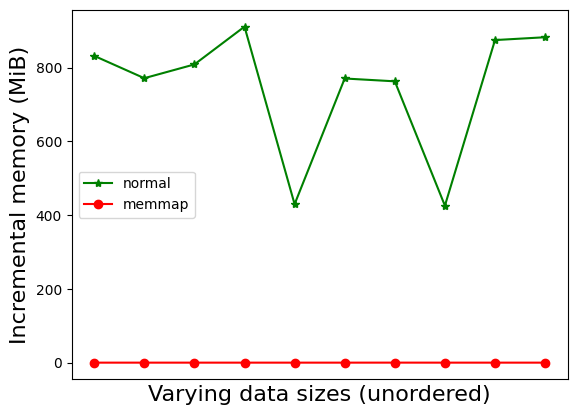

In [49]:
# plot increments over time
import matplotlib.pyplot as plt
plt.plot(increments_normal,'g*-', label='normal')
plt.plot(increments_memmap, 'ro-', label='memmap')
plt.legend()
plt.xlabel("Varying data sizes (unordered)", fontsize=16)
plt.xticks([])
plt.ylabel("Incremental memory (MiB)", fontsize=16)
#plt.ylim(0,1000)
plt.show()

Notice how the same function call using the same input data yielded vastly different memory usage. Numpy's memory mapping is especially useful when only smaller portions of the array are needed at any given time and not the full array. Read more - https://pythonspeed.com/articles/mmap-vs-zarr-hdf5/

In general, memory mapping is another way to perform file I/O that can result in better performance and memory efficiency. For Python's native API, read https://docs.python.org/3/library/mmap.html

You are likely to encounter memory issues primarily due to two reasons: 1) either your computational procedure/algorithm requires too much space to compute the result (example - creating too many temporary intermediate variables or data structures) or it needs to use data contained in very large files (example - loading a dataset of 10,000 medical images).

Despite the simplicity in how memory leaks/issues emerge, there is no one-size-fits-all strategy to handling large files or computations. Nonetheless, a useful first exercise is to characterize your problem along the following dimensions:
- **Compute patterns**
    - Can I re-use intermediate results from previous iterations in the current iteration of the algorithm?
    - Can I re-define my algorithm to use a different and more efficient data structure?
    - How long do I need to keep a particular variable alive in the program?
    - How exact a result do I need? In other words, can you tolerate an approximate result that is far easier to compute?
    - Are there language-specific optimizations you could do?
    - Does my program use concurrency or parallelism to read the same data?
- **Data access patterns**
    - How much of the data in the file do I need to use at any given time? All of it or smaller portions of it?
    - How frequently do I need the data? Does it need to be always available to use?
    - Read vs. write? Do I want to over-write the data or only read it?
    - Do I want multiple programs to read/write to the same file?
- **Storage options**
    - In what type of physical/network storage can the file be best stored?
    - Does the numerical data format used accurately and efficiently represent the information contained in the data? 
    - Can I effectively compress the data without losing the information I need?
    - Would storing the data in a database help?
- **Memory and compute trade-offs / space-time trade-offs**
    - Would computing a quantity on-the-fly be more efficient than reading it from a file?
    
    
We may be able to build a strategy that fits our needs and constraints by thinking about questions like these. Although throwing money at the problem is always an available option, i.e., buying more/better compute and storage hardware, it is best to consider it as a last resort. As unbelievable as it may sound, the Apollo Guidance Computer used in NASA's Apollo 11 space mission in fact "....only had 32,768 bits of Random Access Memory and only 72KB of Read-Only Memory...." - https://interestingengineering.com/innovation/in-defense-of-the-apollo-programs-guidance-computer

# Delete all files that are not needed for submission

In [50]:
!rm big_data.npy
!rm mprofile_*.dat
!rm *.log
!rm my_func.png

---------------
--------------
## Ensure only relevant files are tracked when submitting this lab!
--------------
--------------

### References:
- https://www.honeybadger.io/blog/memory-management-in-python/
- https://www.cs.swarthmore.edu/~kwebb/cs31/f18/memhierarchy/mem_hierarchy.html
- https://realpython.com/python-mmap/
- https://fa.bianp.net/blog/2014/plot-memory-usage-as-a-function-of-time/
- https://pythonspeed.com/articles/mmap-vs-zarr-hdf5/